## GANs : Generative Adversarial Networks 


Image from [here]()
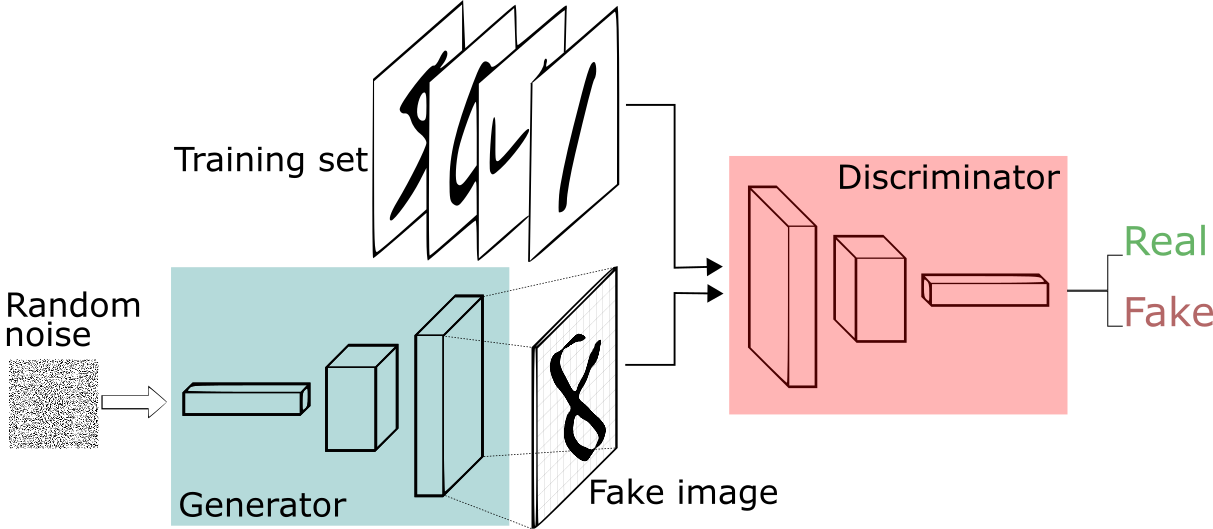

A generative adversarial network (GAN) is a generative model composed of two neural networks: a generator and a discriminator. These two networks are trained in unsupervised way via competition. The generator creates ”realistic” fake images from random noise to fool the discriminator, while the discriminator evaluates the given image for authenticity. 
The loss function that the generator wants to minimize and the discriminator to maximize is as follows: 

min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))] 

Here, G and D are the generator and the discriminator. The first and second term of the loss represent the correct prediction of the discriminator on the real images and on the fake images respectively. 




In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([
                               transforms.ToTensor(),
                               ])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw




## Model Definition

In [2]:
from torch.nn.modules.activation import Sigmoid
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()

        self.fc1 = nn.Linear(100, 128 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(128, 128, 4, 2, padding=0)
        self.conv2 = nn.ConvTranspose2d(128, 128, 4, 2, padding=0)
        self.conv3 = nn.Conv2d(128, 1, 7, padding=0)
        

    def forward(self, input):

        bs, latent, _, _ = input.shape
        x = self.fc1(input.squeeze())
        x = x.view(bs, 128, 7, 7)
        # print(x.shape)
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        out = torch.tanh(x)

        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, 2),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2304, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
        
    
    def forward(self, input):
        bs, in_channel, _, _ = input.shape
        x = self.conv(input)
        out = self.fc(x.view(bs, -1))
        
        return out


g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
out = g(z)
print(out.size()) # You should expect size [batchsize, 1, 28, 28]



d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
out = d(x)
print(out.size()) # You should expect size [batchsize, 1]

torch.Size([2, 1, 28, 28])
torch.Size([2, 1])


In [3]:
import torch
# min G max D L(D, G) = Ex∼pdata(x)[log D(x)] + Ez∼pz(z)[log(1 − D(G(z)))] 
def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    D.zero_grad()
    real_pred = D(real).squeeze()
    fake_imgs = G(noise)
    fake_pred = D(fake_imgs.detach()).squeeze()
    loss_D = criterion(real_pred, Valid_label) + criterion(fake_pred, Fake_label)

    # optimizerD.zero_grad()
    loss_D.backward()
    optimizerD.step()
    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    netG.zero_grad()
    fake_pred = netD(fake).squeeze()
    loss_G = criterion(fake_pred, Valid_label)

    # optimizerG.zero_grad()
    loss_G.backward()
    optimizerG.step()

    return loss_G

In [4]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 6272]         633,472
   ConvTranspose2d-2          [-1, 128, 16, 16]         262,272
   ConvTranspose2d-3          [-1, 128, 34, 34]         262,272
            Conv2d-4            [-1, 1, 28, 28]           6,273
Total params: 1,164,289
Trainable params: 1,164,289
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.43
Params size (MB): 4.44
Estimated Total Size (MB): 5.87
----------------------------------------------------------------
None
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 13, 13]             640
         LeakyReLU-2           [-1, 64, 13, 13]               0
            Conv2d-3            

TRAINING

In [27]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters() , lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters() , lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 20

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        loss_D, fake_imgs = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion, optimizerD)
        loss_G = loss_generator(netD, netG, fake_imgs, Valid_label, criterion, optimizerG)

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))


[0/20][0/600]	Loss_D: 1.3836	Loss_G: 0.6984	
[0/20][50/600]	Loss_D: 1.3053	Loss_G: 2.2805	
[0/20][100/600]	Loss_D: 0.7518	Loss_G: 1.8410	
[0/20][150/600]	Loss_D: 1.5443	Loss_G: 0.8666	
[0/20][200/600]	Loss_D: 1.0280	Loss_G: 1.0243	
[0/20][250/600]	Loss_D: 0.9556	Loss_G: 0.9349	
[0/20][300/600]	Loss_D: 1.0410	Loss_G: 1.6808	
[0/20][350/600]	Loss_D: 0.9849	Loss_G: 1.0933	
[0/20][400/600]	Loss_D: 0.9505	Loss_G: 1.3231	
[0/20][450/600]	Loss_D: 0.9200	Loss_G: 0.9925	
[0/20][500/600]	Loss_D: 1.0010	Loss_G: 1.3284	
[0/20][550/600]	Loss_D: 1.1333	Loss_G: 0.6849	
[1/20][0/600]	Loss_D: 0.8157	Loss_G: 1.7485	
[1/20][50/600]	Loss_D: 0.7915	Loss_G: 1.5490	
[1/20][100/600]	Loss_D: 0.9295	Loss_G: 0.8585	
[1/20][150/600]	Loss_D: 0.8094	Loss_G: 0.9154	
[1/20][200/600]	Loss_D: 1.0097	Loss_G: 1.1425	
[1/20][250/600]	Loss_D: 0.8114	Loss_G: 0.9451	
[1/20][300/600]	Loss_D: 0.5579	Loss_G: 1.3601	
[1/20][350/600]	Loss_D: 0.8331	Loss_G: 1.8208	
[1/20][400/600]	Loss_D: 0.6211	Loss_G: 1.2888	
[1/20][450/600]	Los



## Qualitative Visualisations

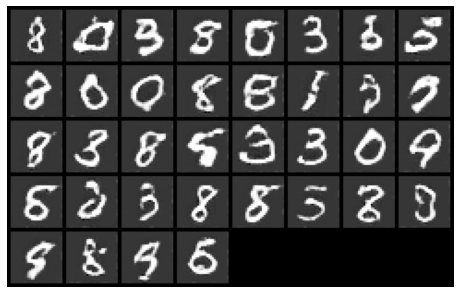

In [28]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

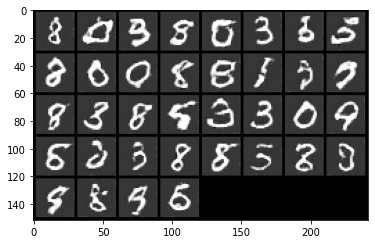

In [29]:
plt.imshow(np.transpose(img_list[-1], (1,2,0)), cmap="gray")

tensor(-0.1583)
tensor(0.9996)


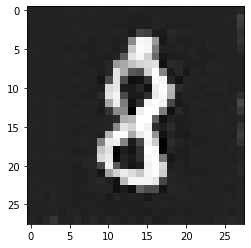

In [30]:
fake_image = netG(fixed_noise)[0][0].detach().cpu()
print(fake_image.min())
print(fake_image.max())
_ = plt.imshow(fake_image, cmap="gray")

# Acknowledge
=============   
This note is mainly based on the assignment of COMS4732 at Columbia by professor Carl Vondrick